## Part 3: Consuming data using Kafka
In this task, we will implement an Apache Kafka consumer to consume the data from part 2.  

- In this part, use Kafka consumer to consume the streaming data published from task 2.8.
- This part doesn’t require parallel processing, you don’t need to use Spark. 
- Please use pandas or Python functions to do the simple calculations for visualisation.

In [1]:
import json
from kafka3 import KafkaConsumer
from datetime import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

def connect_kafka_consumer(hostip, topic):
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

In [3]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time Data Visualization')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Applications')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    




    


    


1. Plot a bar chart showing the number of applications and the number of predicted default applications side-by-side(see the illustration from the specification as an example). For every batch, your diagram will be updated with two additional bars. The x-axis is datetime, y-axis is the number of applications.


In [4]:
def consume_messages(consumer, fig, ax):
    timestamps = []  # Datetime objects for x-axis
    total_apps = []  # Total applications for y-axis (blue bars)
    default_apps = []  # Potential default applications for y-axis (red bars)
    try:
        for message in consumer:
            data = json.loads(message.value.decode('utf-8'))
            timestamp = pd.to_datetime(data['window']['start'])
            total_app = data['total_num_applications']
            default_app = data['num_potential_default_applications']

            # Append new data
            timestamps.append(timestamp)
            total_apps.append(total_app)
            default_apps.append(default_app)

            # Convert timestamps to matplotlib date format
            mpl_dates = mdates.date2num(timestamps)

            # Clear the current plot
            ax.clear()

            # Define bar width and positions
            width = 0.2  # Width of the bars
            ind = np.arange(len(timestamps))  # The x locations for the groups

            # Plot side-by-side bars
            ax.bar(ind, total_apps, width=width, label='Total Applications', color='blue')
            ax.bar(ind + width, default_apps, width=width, label='Potential Default Applications', color='red')

            # Formatting plot with date on x-axis
            ax.xaxis_date()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            ax.set_xlabel('Time')
            ax.set_ylabel('Number of Applications')
            ax.set_ylim(0, max(total_apps + default_apps) + 10)
            ax.set_xticks(ind + width / 2)
            ax.set_xticklabels([date.strftime('%H:%M') for date in timestamps])
            ax.legend()

            # Draw the new plot
            fig.canvas.draw()
            plt.pause(1)
            # Optionally, limit the number of bars displayed at once
            if len(timestamps) > 10:
                timestamps.pop(0)
                total_apps.pop(0)
                default_apps.pop(0)

        plt.close(fig)
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


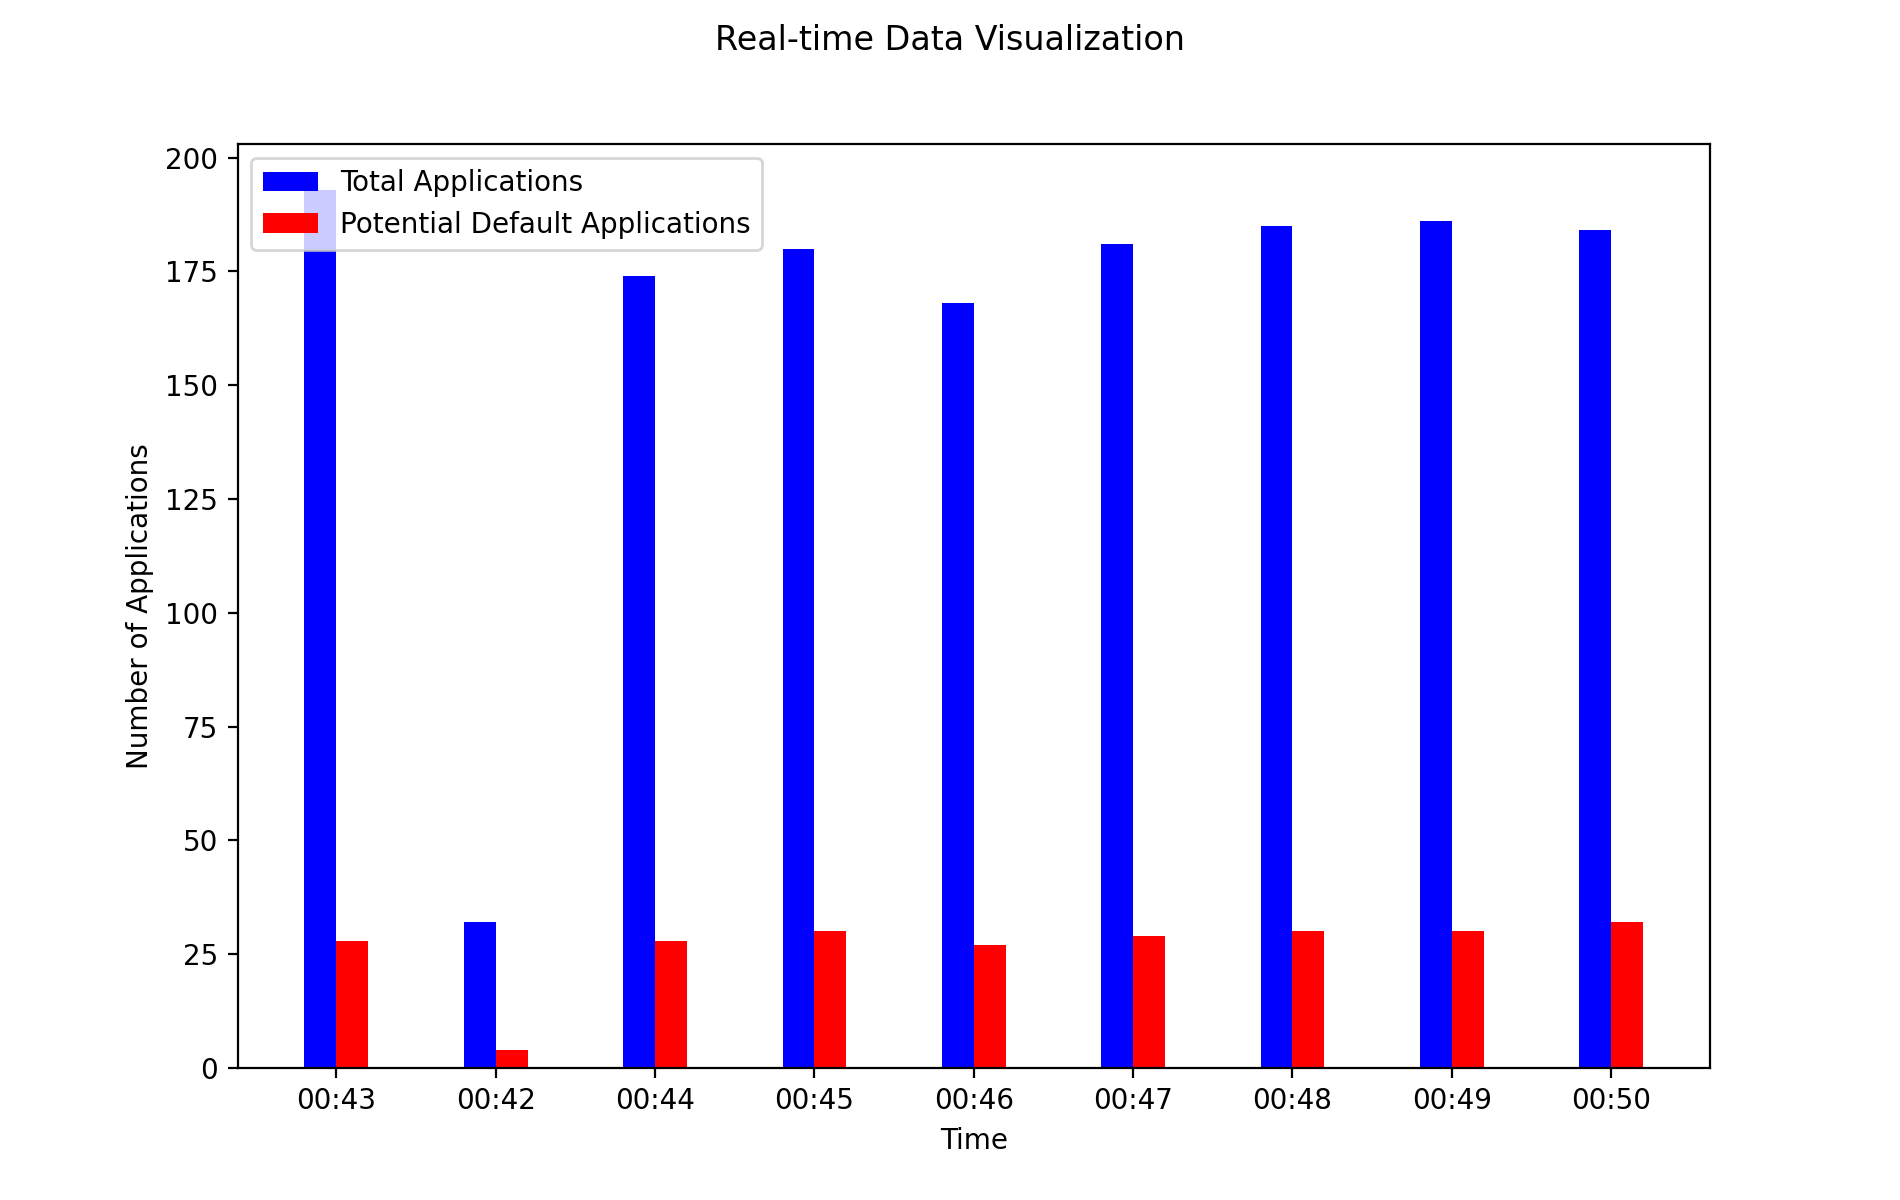

KeyboardInterrupt: 

In [5]:
if __name__ == '__main__':
    #configuration
    hostip = "host.docker.internal" #change me

    topic = 'topic_8a1'
    consumer = connect_kafka_consumer(hostip, topic)
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

2. With streaming data from 7b’s Kafka topic, plot a cumulative line chart and bar chart of required credits, and annotate every 15 seconds with a numerical valued label. Please see the figure from the specification as an example.


<IPython.core.display.Javascript object>


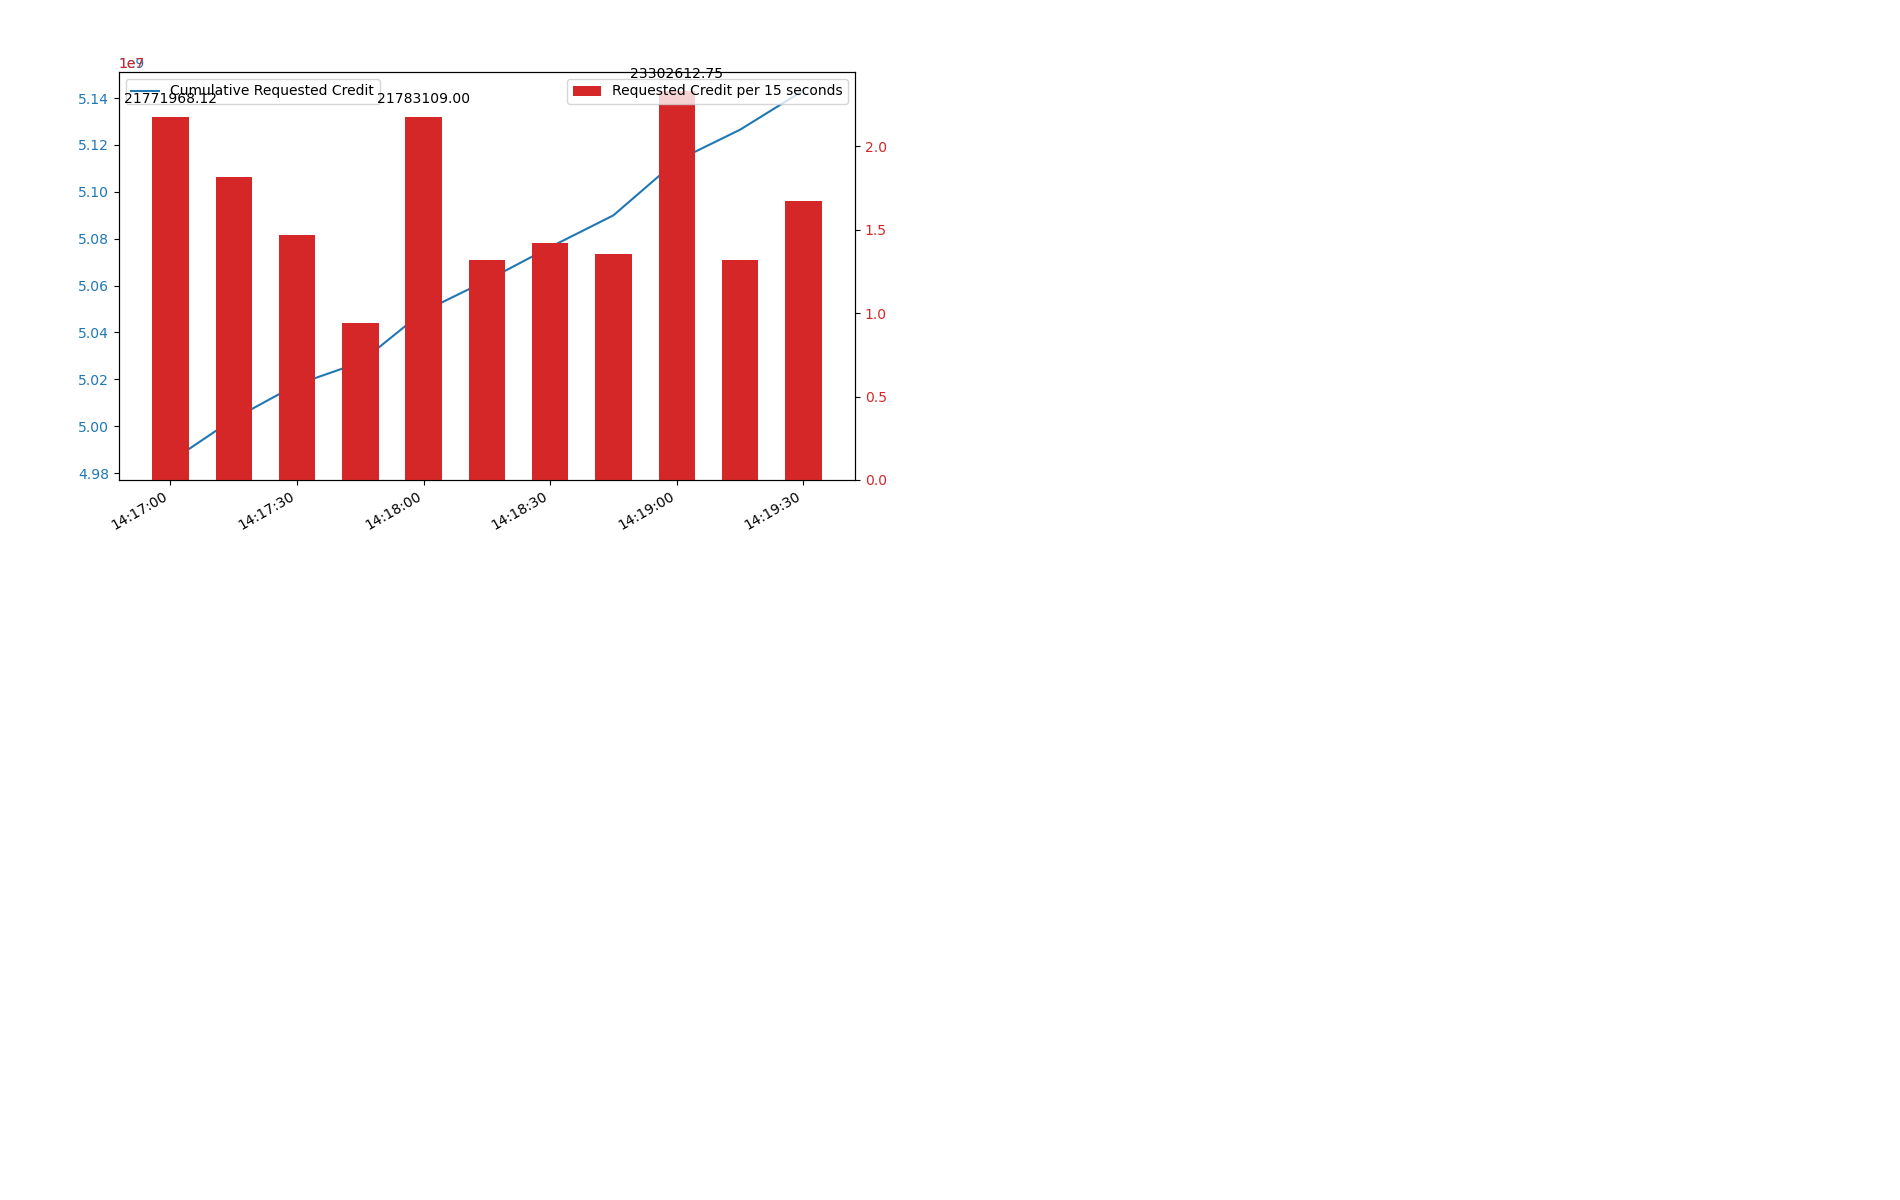

In [ ]:
# Initialize the plots for live streaming data
def init_plots_b():
    try:
        plt.ion()  # Turn on interactive mode
        fig, ax1 = plt.subplots(figsize=(9.5, 6)) 
        ax1.set_xlabel('Time')  # X-axis label
        ax1.set_ylabel('Cumulative Requested Credit', color='tab:blue')  
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Requested Credit per 15 seconds', color='tab:red')  
        return fig, ax1, ax2
    except Exception as ex:
        print(str(ex))

# Consume messages and update the plot
def consume_messages(consumer, fig, ax1, ax2):
    cumulative_credits = 0  
    timestamps = [] 
    credits = []  # List to store credits per 15 seconds
    cumulative_credits_list = []  # List to store cumulative credits

    for message in consumer:
        data = json.loads(message.value.decode('utf-8'))  
        timestamp = datetime.fromisoformat(data['window']['start']) 
        credit = data['total_requested_credit']  
        
        cumulative_credits += credit  # Update cumulative credits
        timestamps.append(timestamp) 
        credits.append(credit)  
        cumulative_credits_list.append(cumulative_credits)  # Append updated cumulative credit

        # Clear the current plot
        ax1.clear()
        ax2.clear()

        # Plot the cumulative line chart
        ax1.plot(timestamps, cumulative_credits_list, color='tab:blue', label='Cumulative Requested Credit')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')

        # Plot the bar chart for requested credit per 15 seconds
        ax2.bar(timestamps, credits, width=0.0001, color='tab:red', label='Requested Credit per 15 seconds')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper right')

       
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        fig.autofmt_xdate()

        # Annotate each 15-second interval
        for (i, (ts, cr)) in enumerate(zip(timestamps, credits)):
            if i % 4 == 0: 
                ax2.annotate(f'{cr:.2f}', (mdates.date2num(ts), cr), textcoords="offset points", xytext=(0,10), ha='center')

        # Limit the number of data points shown on the plot
        if len(timestamps) > 10:  
            timestamps.pop(0)
            credits.pop(0)
            cumulative_credits_list.pop(0)

        # Draw the new plot
        fig.canvas.draw()
        plt.pause(0.5)  # Pause for a short while to update the plot

    plt.close(fig)  # Close the figure to avoid resourc


if __name__ == '__main__':
     #configuration
    hostip = "host.docker.internal" 
    topic = 'topic_8b'
    consumer = connect_kafka_consumer(hostip, topic)
    fig, ax1, ax2 = init_plots_b()
    consume_messages(consumer, fig, ax1, ax2)